In [162]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get Images

In [163]:
MNIST_PATH = './Dataset/'

In [164]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [165]:
#Training set
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

##Validation set
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

##Test set
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

## Normalize images

In [166]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [167]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [168]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

## Show Images

In [169]:
x_test.shape

(10000, 784)

In [170]:
y_train.shape

(50000, 1)

In [171]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 0


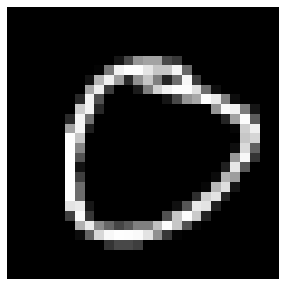

In [172]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Create Mini Batches

# Verify if we need this function

In [173]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Pytorch 

# Investigar que es un tensor. Vamos a tener que poner esto en el marco teorico

https://stackabuse.com/numpy-array-to-tensor-and-tensor-to-numpy-array-with-pytorch/

In [174]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

In [175]:
print(x_train_tensor.dtype)

torch.float32


In [176]:
idxs = np.arange(x_train_tensor.shape[0], dtype=float)
print(idxs[-1])
o = [0,1,2,3,4]
np.random.shuffle(idxs)
x_train_tensor[idxs]

49999.0


tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]])

# We need to research about how we can use the GPU to process the models

https://stackoverflow.com/questions/60987997/why-torch-cuda-is-available-returns-false-even-after-installing-pytorch-with

## Use GPU when available

In [177]:
torch.cuda.is_available()

False

In [178]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cpu


# Accuracy

In [179]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

# Train

In [180]:
def train(model: nn.Sequential, optimiser: torch.optim.SGD, mb_size: int, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')

# Def Model

In [181]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 5e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size, epochs)

Epoch: 0, costo: 1.8925318717956543, accuracy: 0.720458984375
Epoch: 1, costo: 1.2621209621429443, accuracy: 0.786865234375
Epoch: 2, costo: 0.8846130967140198, accuracy: 0.847900390625
Epoch: 3, costo: 0.6270560622215271, accuracy: 0.871337890625
Epoch: 4, costo: 0.5465323328971863, accuracy: 0.88720703125
Epoch: 5, costo: 0.508352518081665, accuracy: 0.88671875
Epoch: 6, costo: 0.4556998908519745, accuracy: 0.8984375
Epoch: 7, costo: 0.3985271453857422, accuracy: 0.892578125
Epoch: 8, costo: 0.4072956144809723, accuracy: 0.906982421875
Epoch: 9, costo: 0.3504480719566345, accuracy: 0.9052734375
Epoch: 10, costo: 0.3408338725566864, accuracy: 0.906494140625
Epoch: 11, costo: 0.3256221413612366, accuracy: 0.912109375
Epoch: 12, costo: 0.3118875324726105, accuracy: 0.912841796875
Epoch: 13, costo: 0.3089389204978943, accuracy: 0.91455078125
Epoch: 14, costo: 0.32218441367149353, accuracy: 0.921875
Epoch: 15, costo: 0.36270222067832947, accuracy: 0.91552734375
Epoch: 16, costo: 0.3058478

In [182]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.96240234375